## Importing libraries and modules

In [0]:
from keras import backend as K
import numpy as np
import time
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,SeparableConv2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout,Concatenate,GlobalAveragePooling2D,Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

## Importing Cifar10 data


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

##  Ploting each class from cifar10 dataset


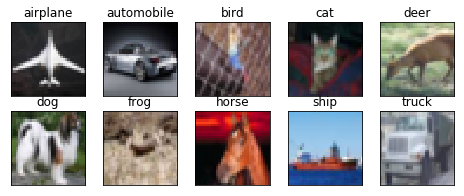

In [79]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Function for ploting model history


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Function for model accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# convert class labels to binary class labels
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Main Model

In [83]:
from keras.models import Model
# Define the model
input = Input(shape=(32,32,3))

# Layer 1 -- normal convolution 3X3
Conv1 = Conv2D(32,(3,3), activation ='relu', padding='same',name ='NormalConv1')(input)
BN1 = BatchNormalization(name='bn1')(Conv1)

# Layer 2 -- Spatially convolution 3X1
SepConv1 = Conv2D(64,(3,1), activation='relu',padding='same', name='SepConv1')(BN1) #3x1
BN2 = BatchNormalization(name='bn2')(SepConv1)

# Layer 3 -- Spatially convolution 1X3
SepConv2 = Conv2D(64,(1,3), activation='relu',padding='same', name='SepConv2')(BN2) #3x1
BN3 = BatchNormalization(name='bn3')(SepConv2)

MaxPool0 = MaxPooling2D((2,2), name='Maxpool0')(BN3)


# Layer 4 -- Depthwise Separable convolution
DepthConv = SeparableConv2D(128,(3,3), activation='relu',padding='same', name='DepthConv')(MaxPool0) 
PointConv = SeparableConv2D(128,(1,1), activation='relu',padding='same', name='PointConv')(DepthConv)
BN4 = BatchNormalization(name='bn4')(PointConv)

# Layer 6 - Group convolution - 
x = Conv2D(128,(3,3), activation='relu',padding='same', name='xG')(BN4) 
BNx = BatchNormalization(name='bn5')(x)

y = Conv2D(128,(5,5), activation='relu',padding='same', name='yG')(BNx) 
BNy = BatchNormalization(name='bn6')(y)

concat_1 =Concatenate(name ='cancat1')([BNx,BNy])
 
concat_2 = Conv2D(128,(5,5), activation='relu',padding='same', name='ycon1')(concat_1) 
concat_output = Convolution2D(128,(1,1), activation='relu',padding='same', name='ycon12')(concat_2) 

# Layer 7 - Group convolution with dialation 

GCD1 = Conv2D(128,(3,3), activation='relu',padding='same', name='GCD1',dilation_rate=1)(concat_output) 
BNp = BatchNormalization(name='bn7')(GCD1)
MaxPool1 = MaxPooling2D((2,2), name='Maxpool1')(BNp)

GCD2 = Conv2D(128,(3,3), activation='relu',padding='same', name='GCD2',dilation_rate=2)(BNp) 
BNq = BatchNormalization(name='bn8')(GCD2)
MaxPool2 = MaxPooling2D((2,2), name='Maxpool2')(BNp)


concat_3 =Concatenate(name ='concat_3')([MaxPool1,MaxPool2])
concat_4 = Conv2D(256,(3,3), activation='relu',padding='same', name='concat_4')(concat_3) 
concat_output_final = Conv2D(256,(1,1), activation='relu',padding='same', name='concat_output_final')(concat_4) 

MaxPool3 = MaxPooling2D((2,2), name='Maxpool3')(concat_output_final)

output1 = Conv2D(10,(8,8), activation='relu',padding='same', name='output1')(MaxPool3) 
output2 = Conv2D(10,(1,1), activation='relu',padding='same', name='output2')(output1) 
output3 = GlobalAveragePooling2D()(output2)
output = Activation('softmax')(output3)

model = Model(inputs=[input], outputs=[output])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
NormalConv1 (Conv2D)            (None, 32, 32, 32)   896         input_28[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 32)   128         NormalConv1[0][0]                
__________________________________________________________________________________________________
SepConv1 (Conv2D)               (None, 32, 32, 64)   6208        bn1[0][0]                        
__________________________________________________________________________________________________
bn2 (Batch

Epoch 1/50
391/390 [==============================] - 40s 102ms/step - loss: 1.8581 - acc: 0.3222 - val_loss: 1.9203 - val_acc: 0.3423
Epoch 2/50
391/390 [==============================] - 31s 80ms/step - loss: 1.3645 - acc: 0.5237 - val_loss: 1.6078 - val_acc: 0.5314
Epoch 3/50
391/390 [==============================] - 31s 79ms/step - loss: 0.9441 - acc: 0.6709 - val_loss: 1.0082 - val_acc: 0.6550
Epoch 4/50
391/390 [==============================] - 31s 79ms/step - loss: 0.7257 - acc: 0.7479 - val_loss: 0.7983 - val_acc: 0.7209
Epoch 5/50
391/390 [==============================] - 31s 79ms/step - loss: 0.6046 - acc: 0.7914 - val_loss: 0.6771 - val_acc: 0.7717
Epoch 6/50
391/390 [==============================] - 31s 79ms/step - loss: 0.5047 - acc: 0.8283 - val_loss: 0.7438 - val_acc: 0.7702
Epoch 7/50
391/390 [==============================] - 31s 79ms/step - loss: 0.4260 - acc: 0.8519 - val_loss: 0.6635 - val_acc: 0.7844
Epoch 8/50
391/390 [==============================] - 31s 79m

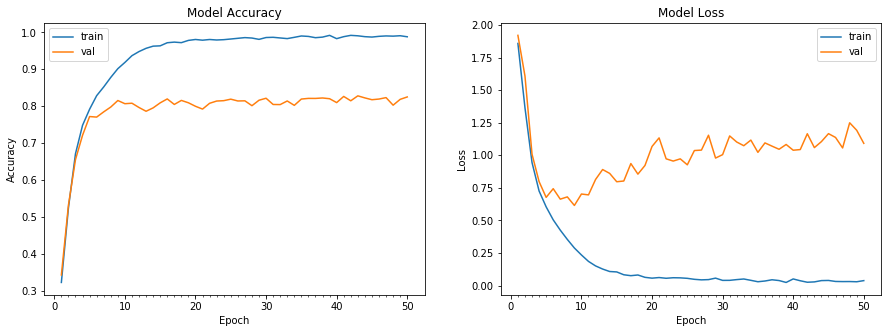

Accuracy on test data is: 82.48


In [84]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False)
# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]/128, epochs = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))